In [142]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.QuadOptimizer.multi_plane_fast import MultiplaneFast
from lenstronomy.LensModel.QuadOptimizer.param_manager import PowerLawFreeShear
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.optimize import minimize
import matplotlib.pylab as pylab
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import Planck15
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from scipy.optimize import linprog
from multiprocessing import Pool
from corner import corner
from matplotlib import cm

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.style.use("science")

In [115]:
SNR = 5.098 # known from original fits file
galfit_data = fits.open("../data/blocks1.fits")
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open("../data/rxj1131_psf1.fits")[0].data
im[im < 0] = 0

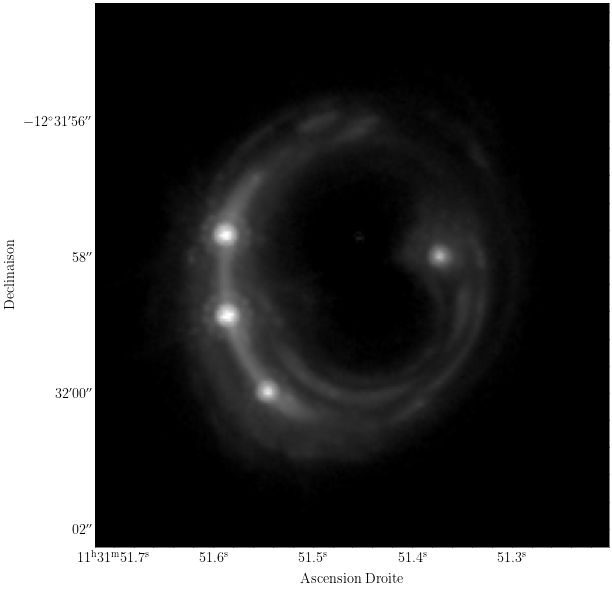

In [116]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="gray", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');
plt.savefig("../latex/beamer_lens/figures/residual.png")

In [117]:
# Trouver la position des 4 images principales
mean, median, std = sigma_clipped_stats(im,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
image_principales = daofind(im).to_pandas().sort_values("flux", ascending=False).iloc[:4]
image_principales

0.017546648 0.0 0.034847353


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
13,14,47.630071,114.149930,0.421323,-0.140638,-0.164836,25,0.0,123.906906,604.727832,-6.953900
8,9,48.316470,84.484198,0.459638,0.277774,-0.305937,25,0.0,121.668182,503.413541,-6.754812
3,4,63.115152,56.540868,0.687271,0.069577,0.076066,25,0.0,65.747673,269.003839,-6.074396
12,13,126.250540,106.427980,0.665696,0.205851,0.011222,25,0.0,17.827728,72.637033,-4.652895


In [118]:
# make a pixel grid and find center pixel
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
x_center = (lens_sky.ra[M//2]).to(u.arcsec)
y_center = (lens_sky.dec[M * N // 2]).to(u.arcsec)

In [119]:
x_image = image_principales["xcentroid"].to_numpy()
y_image = image_principales["ycentroid"].to_numpy()
positions = wcs.pixel_to_world(x_image, y_image)
x_image = (positions.ra - x_center).to(u.arcsec).value
y_image = (positions.dec - y_center).to(u.arcsec).value

In [120]:
z_lens = 0.295
z_source = 0.654
def NIE_backward_model(params, x_image, y_image):
    x0l, y0l, e, phi, x_c, r_ein = params
    # x0l : ra of lens (in as)
    # y0l: dec of lens (in as)
    # r_ein: Einstein radius (in mas)
    # e: ellipticity parameter
    # phi: orientation of the lens [0, pi]
    # x_c: central radius
    # x0, y0: position of the source
    # width: width of the source
    def psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        return np.sqrt(1/(1 - e)*theta1**2 + (1 - e)*theta2**2 + x_c**2)

    def grad_psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        p = psi(grid/r_ein)
        grad1 =  r_ein * theta1 / p / (1 - e)
        grad2 =  r_ein * (1 - e) * theta2 / p
        return np.column_stack([grad1, grad2])

    def rotate(grid, phi):
        rho = np.hypot(grid[:, 0], grid[:, 1])
        varphi = np.angle(grid[:, 0] + 1j*grid[:, 1]) - phi
        rotated_theta1 = rho * np.cos(varphi)
        rotated_theta2 = rho * np.sin(varphi)
        return np.column_stack([rotated_theta1, rotated_theta2])
    
    theta = np.column_stack([x_image, y_image])
    theta = rotate(theta, phi)
    theta1 = theta[:, 0] - x0l
    theta2 = theta[:, 1] - y0l
    theta = np.column_stack([theta1, theta2])
    
    alpha = grad_psi(theta) # deflection angles
    beta  = theta - alpha # lens equation
    return beta

def likelihood(params, x_image, y_image, tolerance):
    beta = NIE_backward_model(params, x_image, y_image)
    betax = beta[:, 0]
    betay = beta[:, 1]
    dx_source = sum([(betax[i] - betax[j])**2 for i in range(3) for j in range(i + 1, 4)])
    dy_source = sum([(betay[i] - betay[j])**2 for i in range(3) for j in range(i + 1, 4)])
    chi_squared = -0.5 * (dx_source + dy_source) / tolerance**2
    return chi_squared

In [121]:
x0l = 0.1
y0l = 0.1
e = 0.1
phi = 0.3
x_c = 0.5
r_ein = 1.6
params =  [x0l, y0l, e, phi, x_c, r_ein]
tolerance = 0.025 # half the pixel scale
likelihood(params, x_image, y_image, tolerance)

-4912.346203779707

In [122]:
bounds = [
    [-1, 1], #x0l
    [-1, 1], # y0l
    [0., 0.4], # e
    [0, np.pi], # phi
    [0.01, 1], #x_c 
    [0, 5], # r_ein
]

def prior_transform(x, bounds=bounds): # uniform distribution
    return [(bounds[i][1] - bounds[i][0]) * x[i] + bounds[i][0] for i in range(x.size)]

def loglike(x):
    return likelihood(x, x_image, y_image, tolerance)

ndim = len(bounds)
with Pool(8) as pool:
    sampler = DynamicNestedSampler(loglike, prior_transform, ndim, pool=pool, queue_size=10, nlive=3000)
    sampler.run_nested()

25531it [02:05, 203.48it/s, batch: 8 | bound: 192 | nc: 5 | ncall: 180759 | eff(%): 14.124 | loglstar: -7.671 < -0.316 < -1.391 | logz: -18.420 +/-  0.243 | stop:  0.992]                 


(<Figure size 1152x1152 with 4 Axes>,
 array([<AxesSubplot:xlabel='$-\\ln X$', ylabel='Live Points'>,
        <AxesSubplot:xlabel='$-\\ln X$', ylabel='Likelihood\n(normalized)'>,
        <AxesSubplot:xlabel='$-\\ln X$', ylabel='Importance\nWeight PDF'>,
        <AxesSubplot:xlabel='$-\\ln X$', ylabel='Evidence'>], dtype=object))

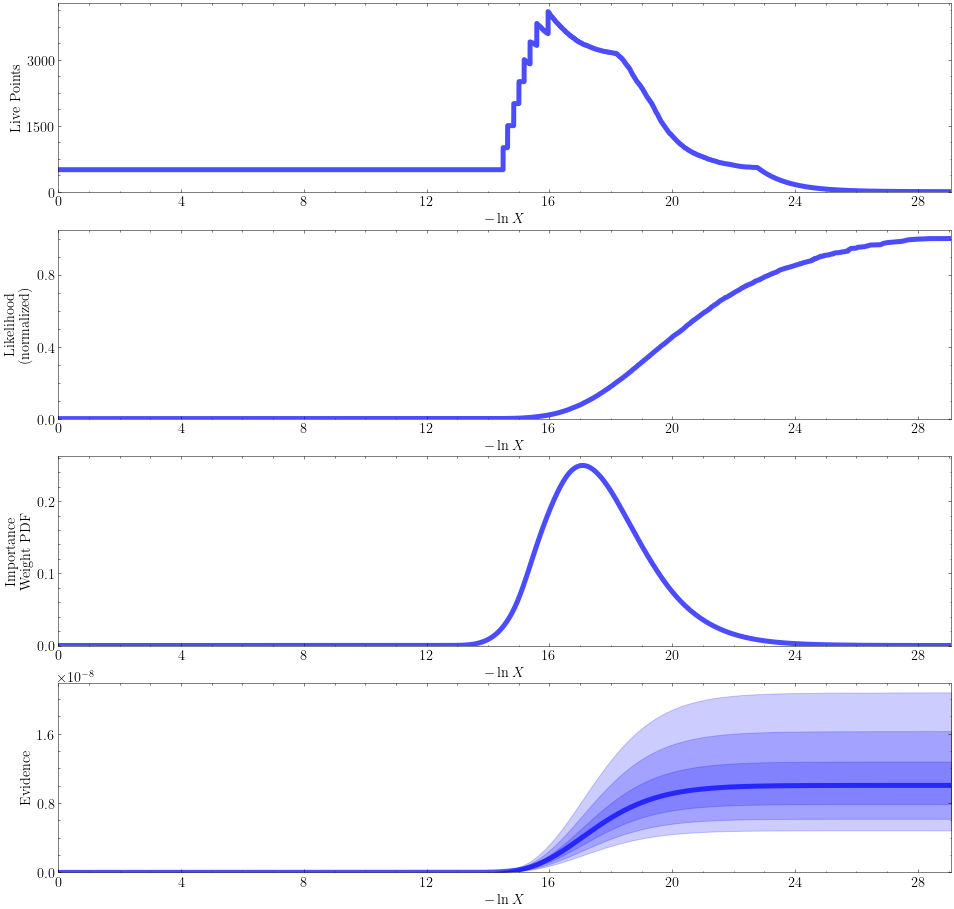

In [124]:
dyplot.runplot(sampler.results)

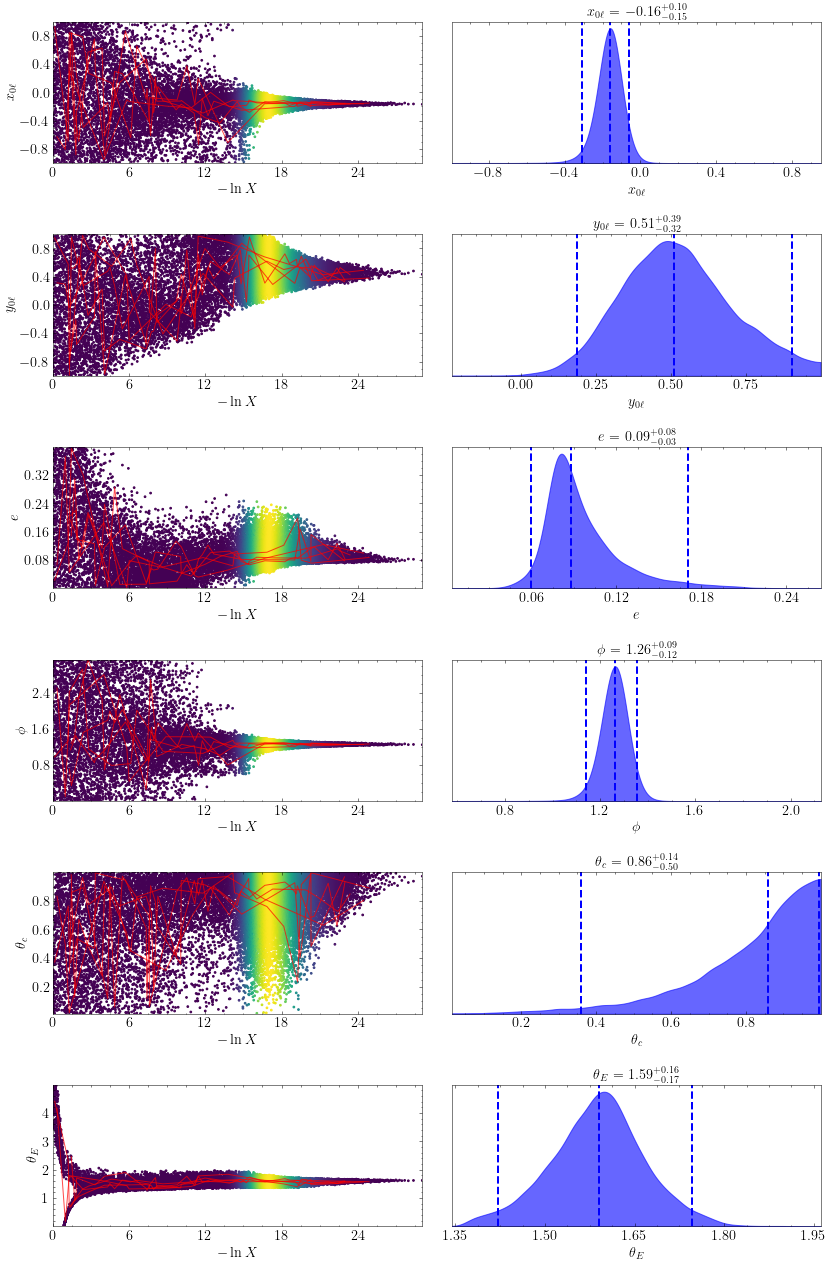

In [125]:
fig, axs = dyplot.traceplot(sampler.results, show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(5),
                            labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$"]
                           );
fig.tight_layout(pad=2.0)
plt.savefig("quasar_image_samples.png")

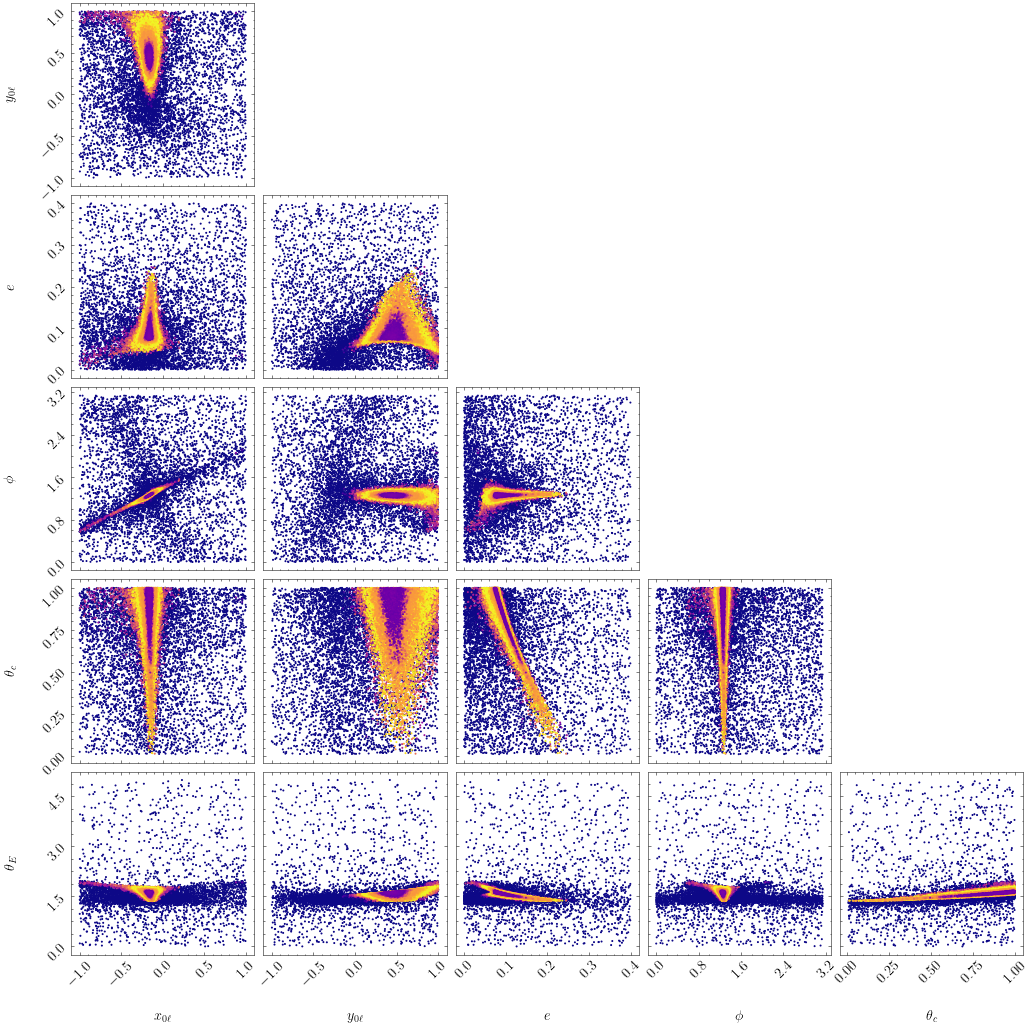

In [134]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes.reshape([5, 5])
# add white space
# [a.set_frame_on(False) for a in axes[:, 2]]
# [a.set_xticks([]) for a in axes[:, 2]]
# [a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (res1; left)
fg, ax = dyplot.cornerpoints(sampler.results, cmap='plasma', kde=False, fig=(fig, axes), 
                             labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$"])

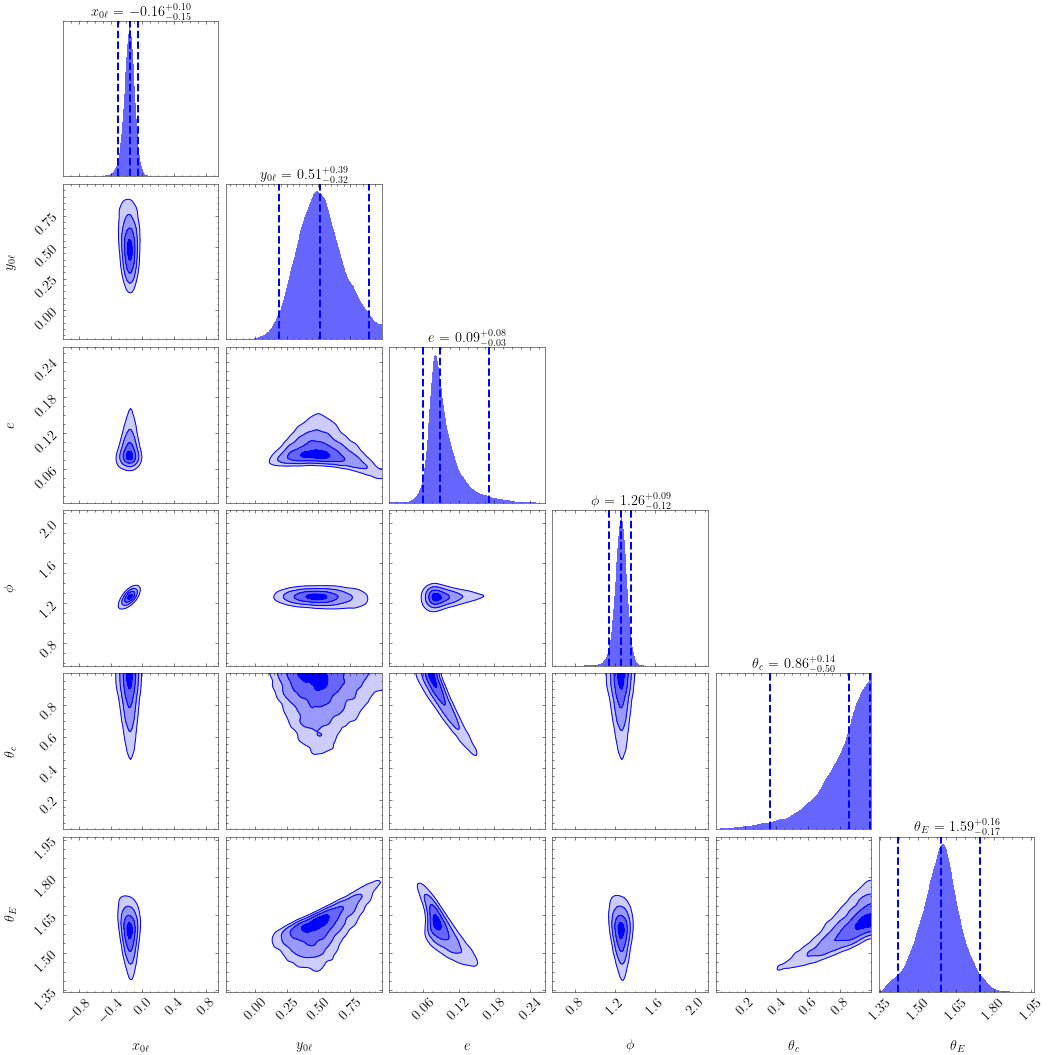

In [145]:
fig, axes = plt.subplots(6, 6, figsize=(15, 15))
axes.reshape([6, 6])
# add white space
# [a.set_frame_on(False) for a in axes[:, 2]]
# [a.set_xticks([]) for a in axes[:, 2]]
# [a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (res1; left)
fg, ax = dyplot.cornerplot(sampler.results, fig=(fig, axes), color="b",
                             labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$"],
                          show_titles=True)
plt.savefig("../latex/beamer_lens/figures/corner_plot.png")

In [ ]:
best = res.samples[np.argmax(res.logl)]

In [ ]:
beta = NIE_backward_model(best, x_image, y_image)

In [ ]:
plt.plot(beta[:, 0], beta[:, 1], "ko")

In [69]:
def NIE_forward_model(params, source_grid, lens_grid):
    x0l, y0l, e, phi, x_c, r_ein, x0, y0, width = params
    # x0l : ra of lens (in as)
    # y0l: dec of lens (in as)
    # r_ein: Einstein radius (in mas)
    # e: ellipticity parameter
    # phi: orientation of the lens [0, pi]
    # x_c: central radius
    # x0, y0: position of the source
    # width: width of the source
    params = [{
        "theta_E": r_ein,
        "gamma": 2,
        "e1": e,
        "e2": 0,
        "s_scale": x_c,
        "center_x": x0l,
        "center_y": y0l
         }]
    def psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        return np.sqrt(1/(1 - e)*theta1**2 + (1 - e)*theta2**2 + x_c**2)

    def grad_psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        p = psi(grid)
        grad1 =  r_ein * theta1 / p / (1 - e)
        grad2 =  r_ein * (1 - e) * theta2 / p
        return np.column_stack([grad1, grad2])

    def rotate(grid, phi):
        rho = np.hypot(grid[:, 0], grid[:, 1])
        varphi = np.angle(grid[:, 0] + 1j*grid[:, 1]) - phi
        rotated_theta1 = rho * np.cos(varphi)
        rotated_theta2 = rho * np.sin(varphi)
        return np.column_stack([rotated_theta1, rotated_theta2])

    def source_model(source_grid, x0, y0, width): # symmetric gaussian profile
        rho = np.hypot(source_grid[:, 0] - x0, source_grid[:, 1] - y0)
        return np.exp(-0.5*rho**2/width**2)/2/np.pi/width**2
    
    theta = rotate(lens_grid, phi)
    theta1 = theta[:, 0] - x0l
    theta2 = theta[:, 1] - y0l
    lens_grid = np.column_stack([theta1, theta2])
    
    alpha  = grad_psi(lens_grid) # deflection angles
    beta   = theta - alpha # lens equation
    I      = source_model(source_grid,  x0, y0, width)
    I_lens = griddata(source_grid, I, (beta[:, 0], beta[:, 1]), method="linear") # ray trace source profile to lens plane
    return I_lens


def likelihood_both(params, image, sigma_vector, psf, source_grid, lens_grid, pixel_map, x_image, y_image, dtheta):
    I_reconstructed = NIE_forward_model(params,  source_grid, lens_grid)
#     I_reconstructed += np.random.normal(0, sigma_vector.ravel(), size=I_reconstructed.shape)
    I_reconstructed = convolve2d(I_reconstructed.reshape(image.shape), psf, mode="same").ravel()
    chi_squared = -0.5 * np.mean((I_reconstructed[pixel_map] - image.ravel()[pixel_map])**2/sigma_vector**2)
    chi_squared +- likelihood(params[:-3], x_image, y_image, dtheta)
    return chi_squared

In [70]:
#lensgrid -> place center in the bottom left corner, not in the center of the image
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
rho = np.hypot(x, y)

In [71]:
# sky coordinate are relative to corner in pixel space
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
# place center in the middle of the array
x_lens = (lens_sky.ra - lens_sky.ra[M//2]).to(u.arcsec).value
y_lens = (lens_sky.dec - lens_sky.dec[M * N // 2]).to(u.arcsec).value
lens_grid = np.column_stack([x_lens.ravel(), y_lens.ravel()])
rho_lens = np.hypot(x_lens, y_lens)
fov = 2 * rho_lens.max()
fov

11.106699410950242

In [72]:
# make fov of source plane about half as small
fov_source = fov/2
# source grid
Ns = N//2 # also make grid with about 4 times less pixel
Ms = M//2
ys = np.linspace(-1, 1, Ns) * fov_source
xs = np.linspace(-1, 1, Ms) * fov_source
xs, ys = np.meshgrid(xs, ys)
source_grid = np.column_stack([xs.ravel(), ys.ravel()])

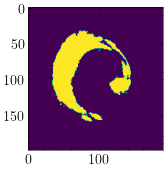

In [73]:
good_pixel_map = np.zeros_like(rho, dtype=bool)
good_pixel_map[im > 0.2] = True
plt.imshow(good_pixel_map)

In [111]:
bounds = [ # informed from previous Nested Sampling call
    [-0.2, 0], #x0l
    [0, 1], # y0l
    [0., 0.2], # e
    [1, 1.5], # phi
    [0.01, 1], #x_c 
    [1, 5], # r_ein
    [-0.2, 0.2], #x0
    [0, 1], # y0
    [0.01, 1] # width
]

def prior_transform(x, bounds=bounds): # uniform distribution
    return [(bounds[i][1] - bounds[i][0]) * x[i] + bounds[i][0] for i in range(x.size)]

ndim = len(bounds)
sigma = np.sqrt(im[good_pixel_map]*1000) # roughly a count
def loglike(x):
    return likelihood_both(x, im, sigma, psf, source_grid, lens_grid, good_pixel_map.ravel(), x_image, y_image, tolerance)
# res = nestle.sample(loglike, prior_transform, ndim=len(bounds), npoints=10)

# with Pool(8) as pool:
#     sampler = DynamicNestedSampler(loglike, prior_transform, ndim, pool=pool, queue_size=10, nlive=3000)
#     sampler.run_nested(maxiter=5000)

In [112]:
# dyplot.runplot(sampler.results)

In [113]:
# fig, axs = dyplot.traceplot(sampler.results, show_titles=True,
#                              trace_cmap='viridis', connect=True,
#                              connect_highlight=range(5),
#                             labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$", r"$x_{0s}$", r"$y_{0s}$", "$\sigma_s$"]
#                            );
# fig.tight_layout(pad=2.0)